In [1]:
%load_ext autoreload
%autoreload 2



In [2]:
#%%
from ntm import NTM
from dataloader import copy_dataloader
from torch import nn, optim
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
#%%

In [3]:
input_size=8+2
output_size=8
controller_size=100
memory_units=128
memory_unit_size=20
batch_size=1
num_heads=1
total_iteration =10000
num_batches = total_iteration//batch_size 

In [4]:
device = torch.device("cpu")
data = copy_dataloader(num_batches,batch_size,8,1,20,device)

ntm = NTM(input_size,output_size,controller_size,memory_units,memory_unit_size,num_heads,device)

criterion = nn.BCELoss()
optimizer = optim.RMSprop(ntm.parameters(),
                          lr=1e-4,
                          alpha=0.95,
                          momentum=0.9)

In [5]:
#%%
print("Starting training")
print_every = 100
losses =[]
errors =[]
best_error = 1e6
for batch, (x,y) in(enumerate(data)):
    optimizer.zero_grad()
    ntm.reset(batch_size)
    
#     print("Sendning inputs")
    for i in range(x.size(0)):
        input = x[i]
        ntm(input)

    outputs = torch.zeros(y.size()).to(device)

    zero_input = torch.zeros([batch_size,input_size]).to(device)
#     print("Finding Outputs")
    for i in range(y.size(0)):
        outputs[i],_ = ntm(zero_input)
    
#     print("Backprop step")
#     print(f"Outputs {outputs}")
#     print(f"y {y}")
    loss = criterion(outputs, y)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_value_(ntm.parameters(), 10)
    optimizer.step()
    
    out_binarized = outputs.clone().data
    out_binarized = out_binarized.cpu().detach().apply_(lambda x: 0 if x < 0.5 else 1).to(device)
    
    # The cost is the number of error bits per sequence
    cost = torch.sum(torch.abs(out_binarized - y.data))
    errors.append(cost.item()/batch_size)
    if (batch%print_every ==0):
        print(f"Finished batch: {batch}, loss:{losses[-1]:.3e}, cost: {errors[-1]}")
        torch.save(ntm.state_dict(), f'checkpoints/copy/v2-{batch}_error_{losses[-1]:.3e}_cost_{int(errors[-1])}.pt')

Starting training
Finished batch: 0, loss:6.982e-01, cost: 18.0
Finished batch: 100, loss:6.868e-01, cost: 37.0
Finished batch: 200, loss:7.004e-01, cost: 44.0
Finished batch: 300, loss:6.930e-01, cost: 60.0
Finished batch: 400, loss:6.931e-01, cost: 17.0
Finished batch: 500, loss:6.989e-01, cost: 30.0
Finished batch: 600, loss:7.079e-01, cost: 19.0
Finished batch: 700, loss:6.970e-01, cost: 60.0
Finished batch: 800, loss:6.874e-01, cost: 39.0
Finished batch: 900, loss:7.040e-01, cost: 78.0
Finished batch: 1000, loss:6.874e-01, cost: 54.0
Finished batch: 1100, loss:7.408e-01, cost: 71.0
Finished batch: 1200, loss:6.656e-01, cost: 50.0
Finished batch: 1300, loss:6.507e-01, cost: 18.0
Finished batch: 1400, loss:6.001e-01, cost: 14.0
Finished batch: 1500, loss:6.718e-01, cost: 60.0
Finished batch: 1600, loss:5.667e-01, cost: 31.0
Finished batch: 1700, loss:4.880e-01, cost: 22.0
Finished batch: 1800, loss:3.747e-01, cost: 5.0
Finished batch: 1900, loss:6.890e-01, cost: 19.0
Finished batch:

In [6]:
mpl.rcParams['figure.dpi']=100
plt.rcParams['image.cmap'] = 'binary_r'
plt.rcParams['image.cmap'] = 'Blues_r'

## Target sequence

Text(0.5,1,'Target Sequence')

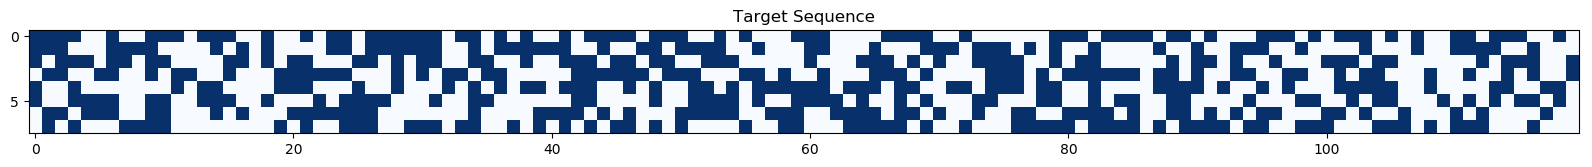

In [52]:
test = copy_dataloader(1,1,8,120,120,device)
x,y = next(test)
plt.figure(figsize=(20,20))
plt.imshow(y.squeeze().t())
plt.title("Target Sequence")

In [53]:
import numpy as np
def print_head(h):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,20))
    fig
    h = np.array(h)
    r = h[:,0,:,:]
    w = h[:,1,:,:]
   # ax1.figure(figsize=(10,20))
    ax1.imshow(r.T.squeeze())
    ax1.set_title("Read Head locations")
#     plt.show()
#     plt.figure(figsize=(10,20))
    ax2.imshow(w.T.squeeze())
    ax2.set_title("Write Head locations")
    plt.show()

In [54]:
ntm_pretrained = NTM(input_size,output_size,controller_size,memory_units,memory_unit_size,num_heads,device)
ntm_pretrained.load_state_dict(torch.load("checkpoints/copy/i-9900_error_0.000e+00_cost_0.pt"))
model = ntm_pretrained
# model = ntm
model.reset(batch_size=1)
with torch.no_grad():
    h1 =[]
    for i in range(x.size(0)):
            input = x[i]
            _,head = model(input)
            h1.append(head)
    outputs = torch.zeros(y.size())
    
    zero_input = torch.zeros([1,input_size])
    #     print("Finding Outputs")
    h2 =[]
    for i in range(y.size(0)):
        outputs[i],head = model(zero_input)
        h2.append(head)
    head_weights = np.concatenate((np.array(h1),np.array(h2)),axis=0)



## Output from network 

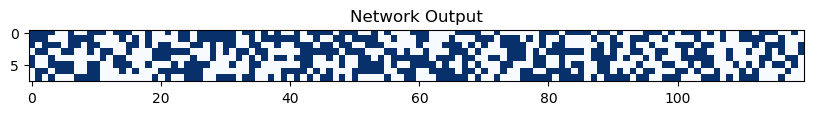

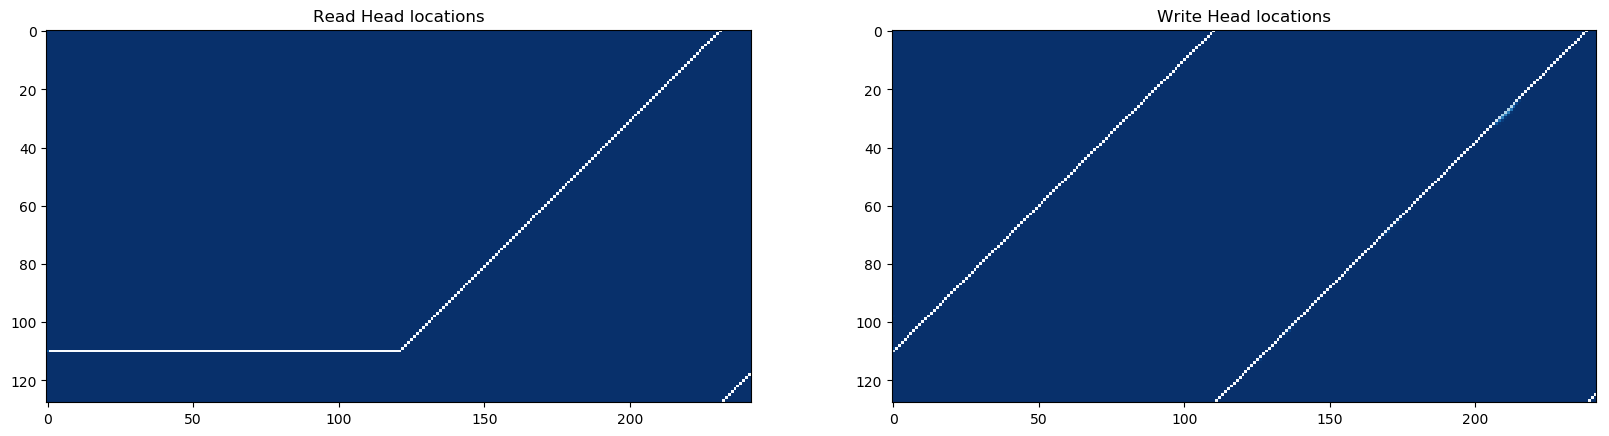

In [55]:
plt.figure(figsize=(10,10))
plt.title("Network Output")
plt.imshow(outputs.squeeze().t())
print_head(head_weights)

## Error between target and output

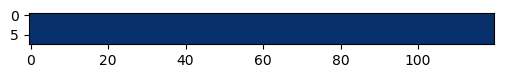

In [46]:
plt.imshow((y-outputs).round().squeeze().t())